In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
pd.set_option("display.max_columns", 50)
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

In [3]:
interactions = pd.read_pickle("../dataset/preprocessed_datasets/preprocessed_interactions.pkl")
users        = pd.read_pickle("../dataset/preprocessed_datasets/preprocessed_users.pkl")
items        = pd.read_pickle("../dataset/preprocessed_datasets/preprocessed_items.pkl")


In [4]:
print("Interactions:", interactions.shape)
print("Users:", users.shape)
print("Items:", items.shape)

Interactions: (1532998, 5)
Users: (142888, 3)
Items: (59599, 5)


### Построение гистограммы распределения акктивности пользователей

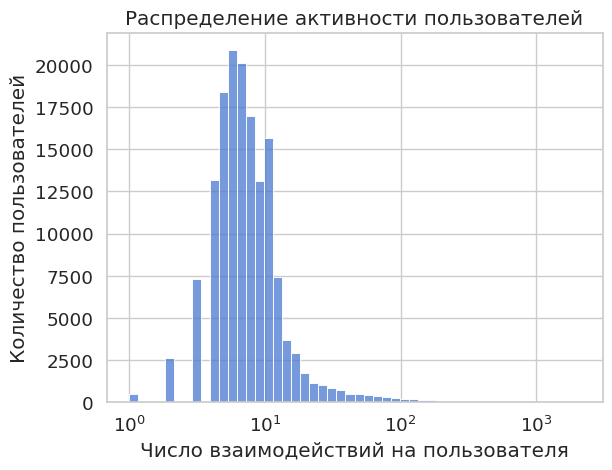

In [5]:
sns.histplot(interactions['user_id'].value_counts(), bins=50, log_scale=True) 
plt.title('Распределение активности пользователей')
plt.xlabel('Число взаимодействий на пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Болшинство пользователей имеет приблизительно от 5 до 20 взаимодействий. 
Есть небольшая группа пользователей (длинный хвост), которые имеют от 20 до 100+ взаимодействий.
Также есть небольшое количество людей,имеющих всего одно взаимодействие с товаром на платформе.
Медианное значение в районе 10 взаимодействий позволит строить моделям довольно уверенные профили пользователей.
Проблема холодного старта незначительна

### Построение гистограммы распределения количества взаимодействий на книгу

Text(0, 0.5, 'Количество товаров')

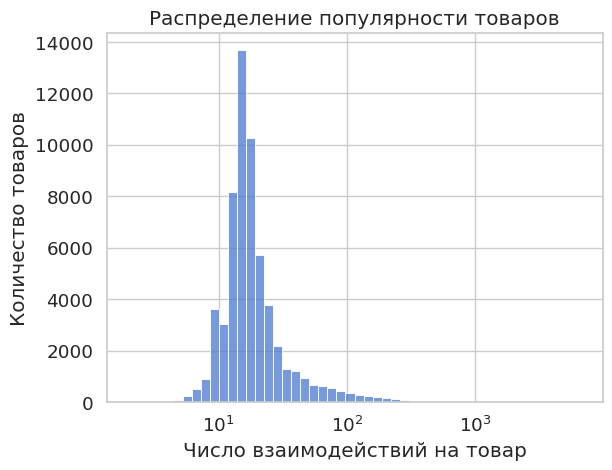

In [6]:
sns.histplot(interactions['item_id'].value_counts(), bins = 50, log_scale=True) 
plt.title('Распределение популярности товаров')
plt.xlabel('Число взаимодействий на товар') 
plt.ylabel('Количество товаров')

Большинство товаров имеют от 5 до 15 взаимодействий.
Также наблюдается длинный хвост сверх-популярных товаров имеющих приблизительно до 500 взаимодейсвий. Это, очевидно, книги-бестселлеры.
Ситуаиция типичная и благоприятная для построения рекомендательных систем.   

### Построение гистограммы распределения рейтингов 

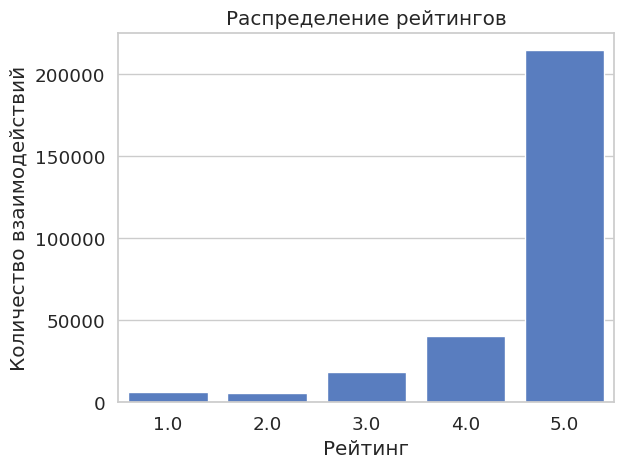

In [7]:
sns.countplot(x='rating', data=interactions)
plt.title("Распределение рейтингов")
plt.xlabel("Рейтинг")
plt.ylabel("Количество взаимодействий")
plt.show()

Наблюдаем сильный дисбаланс классов: колоссальное (более 200000 взаимодействий) смещение оценки в пользу рейтинга 5.0.
Можно предположить, что пользователи чаще оценивают книги только в случае высокой удовлетворённости, а недовольные пользователи не ставят оценку вовсе.
В контексте построения модели на предсказание рейтинга, модель будет склонна к переоценке книг, особенно популярных.
Также вероятно, что многие оценки являются результатом "накрутки" от продавцов. 

### Построение гистограммы распределения прогресса прочтения книги

Text(0, 0.5, 'Количество взаимодействий')

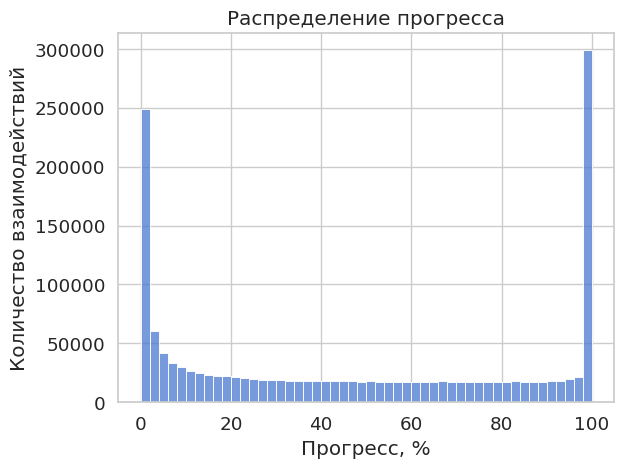

In [8]:
sns.histplot(interactions['progress'], bins=50)
plt.title('Распределение прогресса')
plt.xlabel('Прогресс, %')
plt.ylabel('Количество взаимодействий')


На данном графике видим бимодальное U-образное распредение.
Первая мода - 0 %. Такое поведение моделирует ситуацию, когда пользователь, например, добвал книгу в "Избранное", чтобы прочитать в будущем. Такие взаимодействия скорее можно интерпретировать как интерес, или "закладка на потом", чем реальное взаимодействие. Тем не менее, данное значение прогресса можно интерпретировать как заинтересованность пользователя по обложке/аннотации, поэтому оно также информативно.

Вторая мода - 100  %. Здесь вариантов может быть много. Например, очевидна отрицательная корреляция между размером произведения и степенью прогресса: короткие рассказы на несколько страниц с большей вероятностью будут прочтены до конца. Также существуют пользователи, которые принципиально дочитывают книги до конца. В любом случае 100% - это надёжный положительный сигнал (книга понравилась или хотя бы не вызвала отторжения) и показывает высокую вовлечённость пользователей в контент. 

Промежуточные значения могут быть следствием  нескольких факторов, но ключевых на мой взгляд 2:
1. Пользователь пока просто не успел дочитать книгу.
2. Пользователь забросил прочтение ввиду потери интереса к произведению.

 ### Построение столбчатой диаграммы прогресса для разных рейтингов

Видим, что для каждого уровня рейтинга встрчеаются

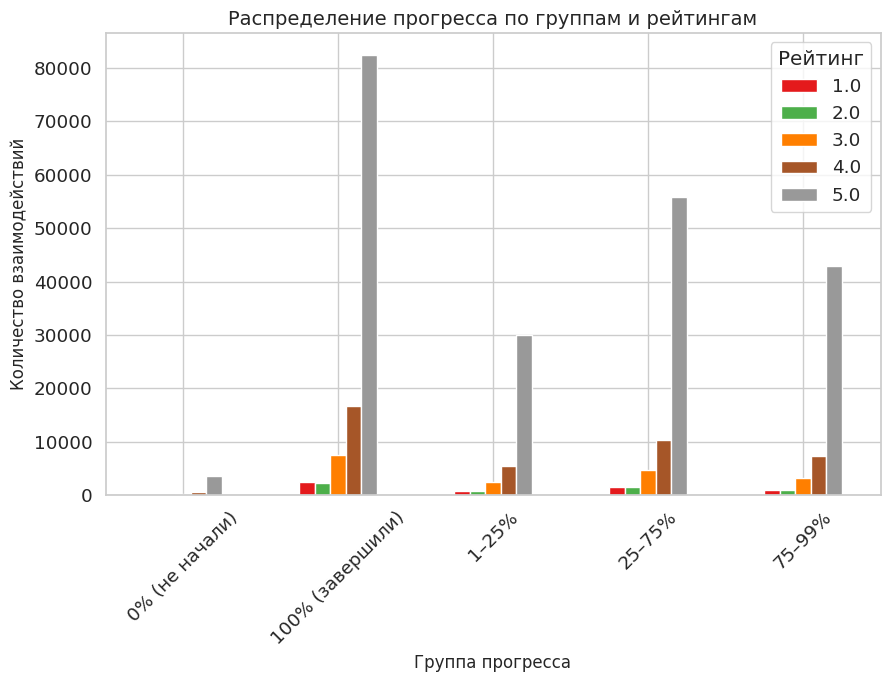

In [9]:
# Категоризация прогресса
def progress_category(p):
    if p == 0:
        return "0% (не начали)"
    elif p < 25:
        return "1–25%"
    elif p < 75:
        return "25–75%"
    elif p < 100:
        return "75–99%"
    else:
        return "100% (завершили)"

interactions["progress_group"] = interactions["progress"].apply(progress_category)


df_grouped = interactions.groupby(["progress_group", "rating"]).size().reset_index(name="count")

df_pivot = df_grouped.pivot(index="progress_group", columns="rating", values="count").fillna(0)


df_pivot.plot(
    kind="bar",
    #stacked=True,
    figsize=(10,6),
    colormap="Set1"
)

plt.title("Распределение прогресса по группам и рейтингам", fontsize=14)
plt.xlabel("Группа прогресса", fontsize=12)
plt.ylabel("Количество взаимодействий", fontsize=12)
plt.legend(title="Рейтинг")
plt.xticks(rotation=45)
plt.show()

Наблюдается заметная группа людей (2к -3к человек), которые поставили рейтинг 5.0 книге, не читая её - возможная "накрутка"
или оценка на основе ожиданий / по обложке / по автору / gпо реценизиям.
В любой группе пользователи склонны ставить позитивные оценки, больше. чем негативные. 
Для каждой группы по прогрессу распределение частот рейтингов сохраняет свою форму. На основе данного наблюдения можно сделать вывод, что рейтинг слабо коррелирует с прогрессом. То есть прогресс сам по себе не является предиктором рейтинга, но тем не менее может давать полезную дополнительную информацию. 